In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,  r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('item_115892_train.csv')
df.head()

id        date  store_nbr  item_nbr  unit_sales onpromotion
0    17  2013-01-01         25    115892        10.0         NaN
1   605  2013-01-02          1    115892        37.0         NaN
2  1623  2013-01-02          2    115892        18.0         NaN
3  2729  2013-01-02          3    115892        55.0         NaN
4  3926  2013-01-02          4    115892        23.0         NaN

In [3]:
df = df.drop(['item_nbr', 'id'], axis=1) #Remove 'item_nbr' (all values the same) and 'id' (previous row numbers) columns
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75290 entries, 0 to 75289
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         75290 non-null  datetime64[ns]
 1   store_nbr    75290 non-null  int64         
 2   unit_sales   75290 non-null  float64       
 3   onpromotion  55836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [4]:
df['day_of_week'] = df['date'].dt.day_name()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    df[f'is_{day.lower()}'] = df['day_of_week'].apply(lambda x: 1 if x == day else 0)

df.head()

date  store_nbr  unit_sales onpromotion day_of_week  is_monday  \
0 2013-01-01         25        10.0         NaN     Tuesday          0   
1 2013-01-02          1        37.0         NaN   Wednesday          0   
2 2013-01-02          2        18.0         NaN   Wednesday          0   
3 2013-01-02          3        55.0         NaN   Wednesday          0   
4 2013-01-02          4        23.0         NaN   Wednesday          0   

   is_tuesday  is_wednesday  is_thursday  is_friday  is_saturday  is_sunday  
0           1             0            0          0            0          0  
1           0             1            0          0            0          0  
2           0             1            0          0            0          0  
3           0             1            0          0            0          0  
4           0             1            0          0            0          0

## Read Stores table and merge with df

In [5]:
stores = pd.read_csv('stores.csv')
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [6]:
df = pd.merge(df, stores, on='store_nbr', how='left')
df

date  store_nbr  unit_sales onpromotion day_of_week  is_monday  \
0     2013-01-01         25        10.0         NaN     Tuesday          0   
1     2013-01-02          1        37.0         NaN   Wednesday          0   
2     2013-01-02          2        18.0         NaN   Wednesday          0   
3     2013-01-02          3        55.0         NaN   Wednesday          0   
4     2013-01-02          4        23.0         NaN   Wednesday          0   
...          ...        ...         ...         ...         ...        ...   
75285 2017-08-15         48        15.0       False     Tuesday          0   
75286 2017-08-15         49        14.0       False     Tuesday          0   
75287 2017-08-15         50         8.0       False     Tuesday          0   
75288 2017-08-15         51        31.0       False     Tuesday          0   
75289 2017-08-15         52         1.0       False     Tuesday          0   

       is_tuesday  is_wednesday  is_thursday  is_friday  is_saturday  \
0               1             0            0          0            0   
1               0             1            0          0            0   
2               0             1            0          0            0   
3               0             1            0          0            0   
4               0             1            0          0            0   
...           ...           ...          ...        ...          ...   
75285           1             0            0          0            0   
75286           1             0            0          0            0   
75287           1             0            0          0            0   
75288           1             0            0          0            0   
75289           1             0            0          0            0   

       is_sunday       city        state type  cluster  
0              0    Salinas  Santa Elena    D        1  
1              0      Quito    Pichincha    D       13  
2              0      Quito    Pichincha    D       13  
3              0      Quito    Pichincha    D        8  
4              0      Quito    Pichincha    D        9  
...          ...        ...          ...  ...      ...  
75285          0      Quito    Pichincha    A       14  
75286          0      Quito    Pichincha    A       11  
75287          0     Ambato   Tungurahua    A       14  
75288          0  Guayaquil       Guayas    A       17  
75289          0      Manta       Manabi    A       11  

[75290 rows x 16 columns]

## Read Holidays table and merge with df

In [7]:
holiday_df = pd.read_csv('holidays_events.csv')
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df = holiday_df.rename(columns={'locale_name': 'city'}) 
holiday_df = holiday_df.drop_duplicates(subset=['date', 'city']) #Remove rows with same date and city
df = pd.merge(df, holiday_df[['date', 'city', 'type', 'transferred']], on=['date', 'city'], how='left')
df = df.rename(columns={'type_x': 'store_type', 'type_y' : 'day_type'}) 
df.head()

date  store_nbr  unit_sales onpromotion day_of_week  is_monday  \
0 2013-01-01         25        10.0         NaN     Tuesday          0   
1 2013-01-02          1        37.0         NaN   Wednesday          0   
2 2013-01-02          2        18.0         NaN   Wednesday          0   
3 2013-01-02          3        55.0         NaN   Wednesday          0   
4 2013-01-02          4        23.0         NaN   Wednesday          0   

   is_tuesday  is_wednesday  is_thursday  is_friday  is_saturday  is_sunday  \
0           1             0            0          0            0          0   
1           0             1            0          0            0          0   
2           0             1            0          0            0          0   
3           0             1            0          0            0          0   
4           0             1            0          0            0          0   

      city        state store_type  cluster day_type transferred  
0  Salinas  Santa Elena          D        1      NaN         NaN  
1    Quito    Pichincha          D       13      NaN         NaN  
2    Quito    Pichincha          D       13      NaN         NaN  
3    Quito    Pichincha          D        8      NaN         NaN  
4    Quito    Pichincha          D        9      NaN         NaN

In [8]:
# Define the holiday logic
def determine_is_holiday(row):
    if row['day_type'] in ['Holiday', 'Additional', 'Bridge', 'Transfer'] and not row['transferred']:
        return 1
    else:
        return 0

# Define the event logic
def determine_is_event(row):
    return 1 if row['day_type'] == 'Event' else 0

In [9]:
# Ensure 'transferred' column is boolean
df['transferred'] = df['transferred'].astype(bool)
# Apply the logic to create the new columns
df['is_holiday'] = df.apply(determine_is_holiday, axis=1)
df = df.drop('day_of_week', axis=1)
df = df.drop('day_type', axis=1) 
df = df.drop('transferred', axis=1) 
df['onpromotion'] = df['onpromotion'].map({True: 1, False: 0})
df.head()

date  store_nbr  unit_sales  onpromotion  is_monday  is_tuesday  \
0 2013-01-01         25        10.0          NaN          0           1   
1 2013-01-02          1        37.0          NaN          0           0   
2 2013-01-02          2        18.0          NaN          0           0   
3 2013-01-02          3        55.0          NaN          0           0   
4 2013-01-02          4        23.0          NaN          0           0   

   is_wednesday  is_thursday  is_friday  is_saturday  is_sunday     city  \
0             0            0          0            0          0  Salinas   
1             1            0          0            0          0    Quito   
2             1            0          0            0          0    Quito   
3             1            0          0            0          0    Quito   
4             1            0          0            0          0    Quito   

         state store_type  cluster  is_holiday  
0  Santa Elena          D        1           0  
1    Pichincha          D       13           0  
2    Pichincha          D       13           0  
3    Pichincha          D        8           0  
4    Pichincha          D        9           0

In [10]:
df.loc[(df['is_sunday'] == 1) | (df['is_saturday'] == 1), 'is_holiday'] = 1
df = df.drop(['is_sunday', 'is_saturday'], axis =1)
df

date  store_nbr  unit_sales  onpromotion  is_monday  is_tuesday  \
0     2013-01-01         25        10.0          NaN          0           1   
1     2013-01-02          1        37.0          NaN          0           0   
2     2013-01-02          2        18.0          NaN          0           0   
3     2013-01-02          3        55.0          NaN          0           0   
4     2013-01-02          4        23.0          NaN          0           0   
...          ...        ...         ...          ...        ...         ...   
75285 2017-08-15         48        15.0          0.0          0           1   
75286 2017-08-15         49        14.0          0.0          0           1   
75287 2017-08-15         50         8.0          0.0          0           1   
75288 2017-08-15         51        31.0          0.0          0           1   
75289 2017-08-15         52         1.0          0.0          0           1   

       is_wednesday  is_thursday  is_friday       city        state  \
0                 0            0          0    Salinas  Santa Elena   
1                 1            0          0      Quito    Pichincha   
2                 1            0          0      Quito    Pichincha   
3                 1            0          0      Quito    Pichincha   
4                 1            0          0      Quito    Pichincha   
...             ...          ...        ...        ...          ...   
75285             0            0          0      Quito    Pichincha   
75286             0            0          0      Quito    Pichincha   
75287             0            0          0     Ambato   Tungurahua   
75288             0            0          0  Guayaquil       Guayas   
75289             0            0          0      Manta       Manabi   

      store_type  cluster  is_holiday  
0              D        1           0  
1              D       13           0  
2              D       13           0  
3              D        8           0  
4              D        9           0  
...          ...      ...         ...  
75285          A       14           0  
75286          A       11           0  
75287          A       14           0  
75288          A       17           0  
75289          A       11           0  

[75290 rows x 14 columns]

In [11]:
df.isnull().sum()*100/df.shape[0] 

date             0.000000
store_nbr        0.000000
unit_sales       0.000000
onpromotion     25.838757
is_monday        0.000000
is_tuesday       0.000000
is_wednesday     0.000000
is_thursday      0.000000
is_friday        0.000000
city             0.000000
state            0.000000
store_type       0.000000
cluster          0.000000
is_holiday       0.000000
dtype: float64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75290 entries, 0 to 75289
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          75290 non-null  datetime64[ns]
 1   store_nbr     75290 non-null  int64         
 2   unit_sales    75290 non-null  float64       
 3   onpromotion   55836 non-null  float64       
 4   is_monday     75290 non-null  int64         
 5   is_tuesday    75290 non-null  int64         
 6   is_wednesday  75290 non-null  int64         
 7   is_thursday   75290 non-null  int64         
 8   is_friday     75290 non-null  int64         
 9   city          75290 non-null  object        
 10  state         75290 non-null  object        
 11  store_type    75290 non-null  object        
 12  cluster       75290 non-null  int64         
 13  is_holiday    75290 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(8), object(3)
memory usage: 8.0+ MB


## Add some columns to use for prediction
- we will add columns, which use values of unit sales. Therefore, we need to remove outliers first

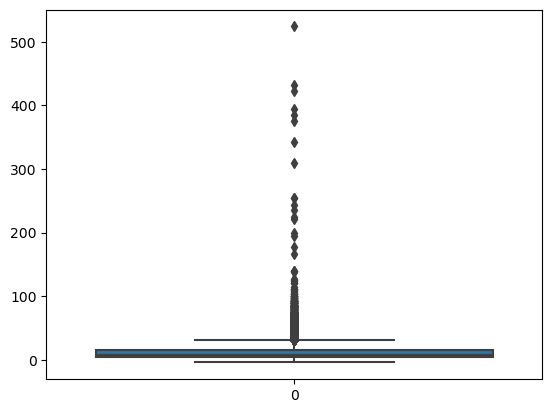

In [13]:
sns.boxplot(df['unit_sales'])
plt.show()

In [14]:
quantile_threshold = df['unit_sales'].quantile(0.995)
quantile_threshold

64.0

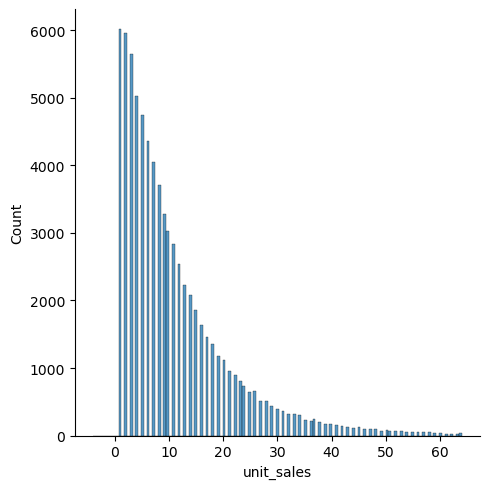

In [15]:
sns.displot(df.query('unit_sales <= 64.0')['unit_sales'])

In [16]:
df = df[df['unit_sales'] < quantile_threshold]

In [17]:
# Define the maximum number of days to shift
max_days = 7

# Sort DataFrame by store and date
df = df.sort_values(by=['store_nbr', 'date'])

# Generate lag features
for i in range(1, max_days + 1):
    df[f'unit_sales_{i}days_ago'] = df.groupby('store_nbr')['unit_sales'].shift(i).fillna(0)
df

date  store_nbr  unit_sales  onpromotion  is_monday  is_tuesday  \
1     2013-01-02          1        37.0          NaN          0           0   
44    2013-01-03          1         4.0          NaN          0           0   
87    2013-01-04          1         5.0          NaN          0           0   
128   2013-01-05          1         7.0          NaN          0           0   
172   2013-01-06          1         2.0          NaN          0           0   
...          ...        ...         ...          ...        ...         ...   
67700 2017-03-06         54         2.0          0.0          1           0   
67749 2017-03-07         54         3.0          1.0          0           1   
67795 2017-03-08         54         1.0          0.0          0           0   
67945 2017-03-12         54         3.0          0.0          0           0   
68476 2017-03-25         54         1.0          0.0          0           0   

       is_wednesday  is_thursday  is_friday       city  ... store_type  \
1                 1            0          0      Quito  ...          D   
44                0            1          0      Quito  ...          D   
87                0            0          1      Quito  ...          D   
128               0            0          0      Quito  ...          D   
172               0            0          0      Quito  ...          D   
...             ...          ...        ...        ...  ...        ...   
67700             0            0          0  El Carmen  ...          C   
67749             0            0          0  El Carmen  ...          C   
67795             1            0          0  El Carmen  ...          C   
67945             0            0          0  El Carmen  ...          C   
68476             0            0          0  El Carmen  ...          C   

      cluster  is_holiday  unit_sales_1days_ago  unit_sales_2days_ago  \
1          13           0                   0.0                   0.0   
44         13           0                  37.0                   0.0   
87         13           0                   4.0                  37.0   
128        13           1                   5.0                   4.0   
172        13           1                   7.0                   5.0   
...       ...         ...                   ...                   ...   
67700       3           0                   8.0                   6.0   
67749       3           0                   2.0                   8.0   
67795       3           0                   3.0                   2.0   
67945       3           1                   1.0                   3.0   
68476       3           1                   3.0                   1.0   

       unit_sales_3days_ago  unit_sales_4days_ago  unit_sales_5days_ago  \
1                       0.0                   0.0                   0.0   
44                      0.0                   0.0                   0.0   
87                      0.0                   0.0                   0.0   
128                    37.0                   0.0                   0.0   
172                     4.0                  37.0                   0.0   
...                     ...                   ...                   ...   
67700                  60.0                   1.0                   1.0   
67749                   6.0                  60.0                   1.0   
67795                   8.0                   6.0                  60.0   
67945                   2.0                   8.0                   6.0   
68476                   3.0                   2.0                   8.0   

       unit_sales_6days_ago  unit_sales_7days_ago  
1                       0.0                   0.0  
44                      0.0                   0.0  
87                      0.0                   0.0  
128                     0.0                   0.0  
172                     0.0                   0.0  
...                     ...                   ...  
67700                   4.0     

In [18]:
months_to_shift = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Extend this list as needed

for months in months_to_shift:
    # Create a new date column shifted by 'months'
    df[f'date_{months}months_ago'] = df['date'] - pd.DateOffset(months=months)

    # Merge the DataFrame with itself on 'store_nbr' and the shifted date
    df = pd.merge(
        df,
        df[['store_nbr', 'date', 'unit_sales']].rename(columns={'date': f'date_{months}months_ago', 'unit_sales': f'unit_sales_{months}months_ago'}),
        on=['store_nbr', f'date_{months}months_ago'],
        how='left'
    )

    # Fill NaN values with 0 (optional)
    df[f'unit_sales_{months}months_ago'] = df[f'unit_sales_{months}months_ago'].fillna(0)

    # Drop the temporary date column
    df = df.drop(columns=[f'date_{months}months_ago'])

In [19]:
years_to_shift = [1, 2, 3]

for years in years_to_shift:
    # Create a new date column shifted by 'years'
    df[f'date_{years}years_ago'] = df['date'] - pd.DateOffset(years=years)

    # Merge the DataFrame with itself on 'store_nbr' and the shifted date
    df = pd.merge(
        df,
        df[['store_nbr', 'date', 'unit_sales']].rename(columns={'date': f'date_{years}years_ago', 'unit_sales': f'unit_sales_{years}years_ago'}),
        on=['store_nbr', f'date_{years}years_ago'],
        how='left'
    )

    # Fill NaN values with 0 (optional)
    df[f'unit_sales_{years}years_ago'] = df[f'unit_sales_{years}years_ago'].fillna(0)

    # Drop the temporary date column
    df = df.drop(columns=[f'date_{years}years_ago'])

#### Example check for a specific date and store
specific_date = pd.to_datetime('2014-01-02') #can be changed
store = 2 # can be changed
df_check_1 = df[df['date'] == specific_date]
df_check_2 = df[df['store_nbr'] == store]
print(df_check_2[['date', 'store_nbr', 'unit_sales', 'unit_sales_4days_ago']])

## Add oil price 

In [20]:
oil = pd.read_csv('oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
# Merge the DataFrame df with the oil DataFrame on the 'date' column
df = pd.merge(df, oil[['date', 'dcoilwtico']], on='date', how='left')
df = df.rename(columns={'dcoilwtico': 'oil_price'})
# Fill the missing values in the dcoilwtico column with the mean value
df['oil_price'] = df['oil_price'].fillna(df['oil_price'].mean())

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74893 entries, 0 to 74892
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     74893 non-null  datetime64[ns]
 1   store_nbr                74893 non-null  int64         
 2   unit_sales               74893 non-null  float64       
 3   onpromotion              55543 non-null  float64       
 4   is_monday                74893 non-null  int64         
 5   is_tuesday               74893 non-null  int64         
 6   is_wednesday             74893 non-null  int64         
 7   is_thursday              74893 non-null  int64         
 8   is_friday                74893 non-null  int64         
 9   city                     74893 non-null  object        
 10  state                    74893 non-null  object        
 11  store_type               74893 non-null  object        
 12  cluster                  74893 n

- Column 'onpromotion' has empty values, which can be predicted using logistic regression.
- After predicting 'onpromotion' values, we will predict 'unit_sales' using linear regression.
- Thus, we need all predictor variable to be quantitative -> need to change 'city', 'state', 'store_type' to quantitative data.
- Before making predictions we need to perform several diagnostics

## Fill empty values 

In [22]:
df['onpromotion'].fillna(0, inplace=True)
# we fill empty values with 0, because if these cells were not filled, then there is a high chance that there was not promotion

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74893 entries, 0 to 74892
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     74893 non-null  datetime64[ns]
 1   store_nbr                74893 non-null  int64         
 2   unit_sales               74893 non-null  float64       
 3   onpromotion              74893 non-null  float64       
 4   is_monday                74893 non-null  int64         
 5   is_tuesday               74893 non-null  int64         
 6   is_wednesday             74893 non-null  int64         
 7   is_thursday              74893 non-null  int64         
 8   is_friday                74893 non-null  int64         
 9   city                     74893 non-null  object        
 10  state                    74893 non-null  object        
 11  store_type               74893 non-null  object        
 12  cluster                  74893 n

## Split one moth data for prediction later on

In [24]:
categorical_columns = ['city', 'state', 'store_type']
mean_encodings = {}

for column in categorical_columns:
    mean_encodings[column] = df.groupby(column)['unit_sales'].mean()
# Function to encode categorical columns with mean values
def encode_mean_values(df, categorical_columns, mean_encodings):
    for column in categorical_columns:
        df[column] = df[column].map(mean_encodings[column]).fillna(0)  # Replace missing categories with 0 or another value
    return df
# Apply encoding to training and test sets
df = encode_mean_values(df.copy(), categorical_columns, mean_encodings)

print("df_encoded:\n", df)

df_encoded:
             date  store_nbr  unit_sales  onpromotion  is_monday  is_tuesday  \
0     2013-01-02          1        37.0          0.0          0           0   
1     2013-01-03          1         4.0          0.0          0           0   
2     2013-01-04          1         5.0          0.0          0           0   
3     2013-01-05          1         7.0          0.0          0           0   
4     2013-01-06          1         2.0          0.0          0           0   
...          ...        ...         ...          ...        ...         ...   
74888 2017-03-06         54         2.0          0.0          1           0   
74889 2017-03-07         54         3.0          1.0          0           1   
74890 2017-03-08         54         1.0          0.0          0           0   
74891 2017-03-12         54         3.0          0.0          0           0   
74892 2017-03-25         54         1.0          0.0          0           0   

       is_wednesday  is_thursday  is_f

In [25]:
# Determine the maximum date and the first date of the last month
max_date = df['date'].max()
first_date_last_month = max_date - pd.DateOffset(months=1)

# Split the data
data = df[df['date'] < first_date_last_month]
last_month_data = df[df['date'] >= first_date_last_month]

In [26]:
last_month_data

date  store_nbr  unit_sales  onpromotion  is_monday  is_tuesday  \
1500  2017-07-15          1         1.0          0.0          0           0   
1501  2017-07-16          1         3.0          0.0          0           0   
1502  2017-07-17          1         3.0          1.0          1           0   
1503  2017-07-18          1        10.0          1.0          0           1   
1504  2017-07-19          1         4.0          1.0          0           0   
...          ...        ...         ...          ...        ...         ...   
74661 2017-08-07         53         2.0          0.0          1           0   
74662 2017-08-08         53         6.0          0.0          0           1   
74663 2017-08-09         53         3.0          0.0          0           0   
74664 2017-08-12         53         1.0          0.0          0           0   
74665 2017-08-14         53         1.0          0.0          1           0   

       is_wednesday  is_thursday  is_friday       city  ...  \
1500              0            0          0  14.772353  ...   
1501              0            0          0  14.772353  ...   
1502              0            0          0  14.772353  ...   
1503              0            0          0  14.772353  ...   
1504              1            0          0  14.772353  ...   
...             ...          ...        ...        ...  ...   
74661             0            0          0   3.925344  ...   
74662             0            0          0   3.925344  ...   
74663             1            0          0   3.925344  ...   
74664             0            0          0   3.925344  ...   
74665             0            0          0   3.925344  ...   

       unit_sales_6months_ago  unit_sales_7months_ago  unit_sales_8months_ago  \
1500                      3.0                     0.0                     5.0   
1501                      4.0                     0.0                    15.0   
1502                      7.0                     0.0                     3.0   
1503                      4.0                     3.0                     1.0   
1504                      0.0                    14.0                     3.0   
...                       ...                     ...                     ...   
74661                     4.0                     2.0                     1.0   
74662                     4.0                     6.0                     0.0   
74663                     4.0                     1.0                     3.0   
74664                     7.0                     0.0                     2.0   
74665                     1.0                     3.0                     0.0   

       unit_sales_9months_ago  unit_sales_10months_ago  \
1500                     14.0                      7.0   
1501                      5.0                      0.0   
1502                      5.0                      8.0   
1503                      7.0                      5.0   
1504                      1.0                     10.0   
...                       ...                      ...   
74661                     6.0                      1.0   
74662                     2.0                      5.0   
74663                     2.0                      9.0   
74664                     2.0                      3.0   
74665                     1.0                      0.0   

       unit_sales_11months_ago  unit_sales_1years_ago  unit_sales_2years_ago  \
1500                       5.0                    2.0                    1.0   
1501                       2.0                    8.0                    2.0   
1502                       7.0                    0.0                    1.0   
1503                       1.0                    0.0                    2.0   
1504                       4.0                    5.0                    0.0   
...                        ...                    ...                    ...   
74661                      7.0                   10.0                    1.0

In [27]:
df = data
df

date  store_nbr  unit_sales  onpromotion  is_monday  is_tuesday  \
0     2013-01-02          1        37.0          0.0          0           0   
1     2013-01-03          1         4.0          0.0          0           0   
2     2013-01-04          1         5.0          0.0          0           0   
3     2013-01-05          1         7.0          0.0          0           0   
4     2013-01-06          1         2.0          0.0          0           0   
...          ...        ...         ...          ...        ...         ...   
74888 2017-03-06         54         2.0          0.0          1           0   
74889 2017-03-07         54         3.0          1.0          0           1   
74890 2017-03-08         54         1.0          0.0          0           0   
74891 2017-03-12         54         3.0          0.0          0           0   
74892 2017-03-25         54         1.0          0.0          0           0   

       is_wednesday  is_thursday  is_friday       city  ...  \
0                 1            0          0  14.772353  ...   
1                 0            1          0  14.772353  ...   
2                 0            0          1  14.772353  ...   
3                 0            0          0  14.772353  ...   
4                 0            0          0  14.772353  ...   
...             ...          ...        ...        ...  ...   
74888             0            0          0   2.784141  ...   
74889             0            0          0   2.784141  ...   
74890             1            0          0   2.784141  ...   
74891             0            0          0   2.784141  ...   
74892             0            0          0   2.784141  ...   

       unit_sales_6months_ago  unit_sales_7months_ago  unit_sales_8months_ago  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
74888                     0.0                     0.0                     0.0   
74889                     0.0                     0.0                     0.0   
74890                     0.0                     0.0                     0.0   
74891                     0.0                     0.0                     0.0   
74892                     0.0                     0.0                     0.0   

       unit_sales_9months_ago  unit_sales_10months_ago  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0.0                      0.0   
...                       ...                      ...   
74888                     0.0                      0.0   
74889                     0.0                      0.0   
74890                     0.0                      0.0   
74891                     0.0                      0.0   
74892                     0.0                      0.0   

       unit_sales_11months_ago  unit_sales_1years_ago  unit_sales_2years_ago  \
0                          0.0                    0.0                    0.0   
1                          0.0                    0.0                    0.0   
2                          0.0                    0.0                    0.0   
3                          0.0                    0.0                    0.0   
4                          0.0                    0.0                    0.0   
...                        ...                    ...                    ...   
74888                      0.0                    0.0                    0.0

## Prediction of unit_sales

In [28]:
df = df[df['unit_sales'] >= 0] #there is only one row with unit_sales<0, let's remove it

In [29]:
X = df.drop(['date', 'unit_sales'], axis = 1)
y = df['unit_sales']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
int(y_train.mean())

11

In [32]:
X_train.columns

Index(['store_nbr', 'onpromotion', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'city', 'state', 'store_type', 'cluster',
       'is_holiday', 'unit_sales_1days_ago', 'unit_sales_2days_ago',
       'unit_sales_3days_ago', 'unit_sales_4days_ago', 'unit_sales_5days_ago',
       'unit_sales_6days_ago', 'unit_sales_7days_ago',
       'unit_sales_1months_ago', 'unit_sales_2months_ago',
       'unit_sales_3months_ago', 'unit_sales_4months_ago',
       'unit_sales_5months_ago', 'unit_sales_6months_ago',
       'unit_sales_7months_ago', 'unit_sales_8months_ago',
       'unit_sales_9months_ago', 'unit_sales_10months_ago',
       'unit_sales_11months_ago', 'unit_sales_1years_ago',
       'unit_sales_2years_ago', 'unit_sales_3years_ago', 'oil_price'],
      dtype='object')

In [33]:
columns_to_replace = [
    'unit_sales_1days_ago', 'unit_sales_2days_ago', 'unit_sales_3days_ago',
    'unit_sales_4days_ago', 'unit_sales_5days_ago', 'unit_sales_6days_ago',
    'unit_sales_7days_ago', 'unit_sales_1months_ago', 'unit_sales_2months_ago',
    'unit_sales_3months_ago', 'unit_sales_4months_ago', 'unit_sales_5months_ago',
    'unit_sales_6months_ago', 'unit_sales_7months_ago', 'unit_sales_8months_ago',
    'unit_sales_9months_ago', 'unit_sales_10months_ago', 'unit_sales_11months_ago',
    'unit_sales_1years_ago', 'unit_sales_2years_ago', 'unit_sales_3years_ago'
]

replacement_value = int(y_train.mean()) 
# we replace 0 values with the mean of unit_sales in train data, because each 0 mean empty value. 

In [34]:
X_train[columns_to_replace] = X_train[columns_to_replace].replace(0, replacement_value)
X_test[columns_to_replace] = X_test[columns_to_replace].replace(0, replacement_value)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73347 entries, 0 to 74892
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     73347 non-null  datetime64[ns]
 1   store_nbr                73347 non-null  int64         
 2   unit_sales               73347 non-null  float64       
 3   onpromotion              73347 non-null  float64       
 4   is_monday                73347 non-null  int64         
 5   is_tuesday               73347 non-null  int64         
 6   is_wednesday             73347 non-null  int64         
 7   is_thursday              73347 non-null  int64         
 8   is_friday                73347 non-null  int64         
 9   city                     73347 non-null  float64       
 10  state                    73347 non-null  float64       
 11  store_type               73347 non-null  float64       
 12  cluster                  73347 non-nu

- Now we have all values in quantitative form, so we can perform our diagnostics. 

## Diagnostics

In [36]:
len(X_train.columns)

34

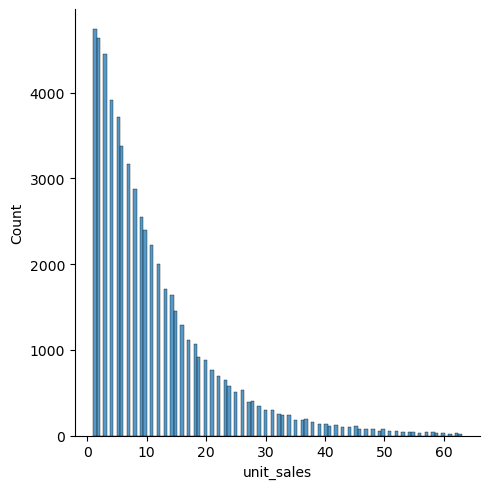

In [37]:
sns.displot(y_train)

- The distribution of unit_sales looks more like exponential

### 1. Multicollinearity

In [38]:
# Compute the correlation matrix
correlation_matrix = X_train.corr()

# Display the correlation matrix
print(correlation_matrix)

                         store_nbr  onpromotion  is_monday  is_tuesday  \
store_nbr                 1.000000     0.010473  -0.001382   -0.003014   
onpromotion               0.010473     1.000000  -0.002167   -0.004187   
is_monday                -0.001382    -0.002167   1.000000   -0.167700   
is_tuesday               -0.003014    -0.004187  -0.167700    1.000000   
is_wednesday              0.002820     0.004320  -0.166311   -0.165621   
is_thursday               0.001656    -0.007621  -0.165116   -0.164431   
is_friday                 0.002477     0.006864  -0.166241   -0.165551   
city                     -0.100338    -0.015702  -0.001150    0.002581   
state                    -0.123230    -0.015427  -0.001768    0.003109   
store_type                0.561721    -0.006788  -0.000716   -0.000594   
cluster                  -0.037997    -0.004646  -0.000433    0.002236   
is_holiday               -0.002141     0.001239  -0.261733   -0.260840   
unit_sales_1days_ago      0.137405    

In [39]:
# Display pairs of variables with high correlation
high_corr_pairs = correlation_matrix[(correlation_matrix.abs() > 0.5) & (correlation_matrix.abs() < 1)]
print(high_corr_pairs)

                         store_nbr  onpromotion  is_monday  is_tuesday  \
store_nbr                      NaN          NaN        NaN         NaN   
onpromotion                    NaN          NaN        NaN         NaN   
is_monday                      NaN          NaN        NaN         NaN   
is_tuesday                     NaN          NaN        NaN         NaN   
is_wednesday                   NaN          NaN        NaN         NaN   
is_thursday                    NaN          NaN        NaN         NaN   
is_friday                      NaN          NaN        NaN         NaN   
city                           NaN          NaN        NaN         NaN   
state                          NaN          NaN        NaN         NaN   
store_type                0.561721          NaN        NaN         NaN   
cluster                        NaN          NaN        NaN         NaN   
is_holiday                     NaN          NaN        NaN         NaN   
unit_sales_1days_ago           NaN    

- there are multicollinearity between store_nbr and store_type, state and city
- we can remove one of them for each

In [40]:
X_train.columns

Index(['store_nbr', 'onpromotion', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'city', 'state', 'store_type', 'cluster',
       'is_holiday', 'unit_sales_1days_ago', 'unit_sales_2days_ago',
       'unit_sales_3days_ago', 'unit_sales_4days_ago', 'unit_sales_5days_ago',
       'unit_sales_6days_ago', 'unit_sales_7days_ago',
       'unit_sales_1months_ago', 'unit_sales_2months_ago',
       'unit_sales_3months_ago', 'unit_sales_4months_ago',
       'unit_sales_5months_ago', 'unit_sales_6months_ago',
       'unit_sales_7months_ago', 'unit_sales_8months_ago',
       'unit_sales_9months_ago', 'unit_sales_10months_ago',
       'unit_sales_11months_ago', 'unit_sales_1years_ago',
       'unit_sales_2years_ago', 'unit_sales_3years_ago', 'oil_price'],
      dtype='object')

In [41]:
# Drop columns from X_train and X_test
X_train = X_train.drop(columns=['store_type', 'city'])
X_test = X_test.drop(columns=['store_type', 'city'])

### 2. Linearity

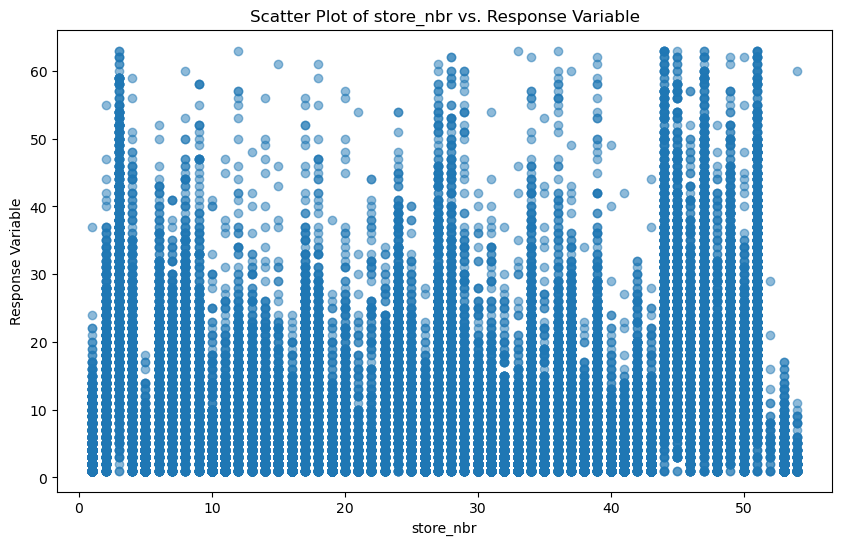

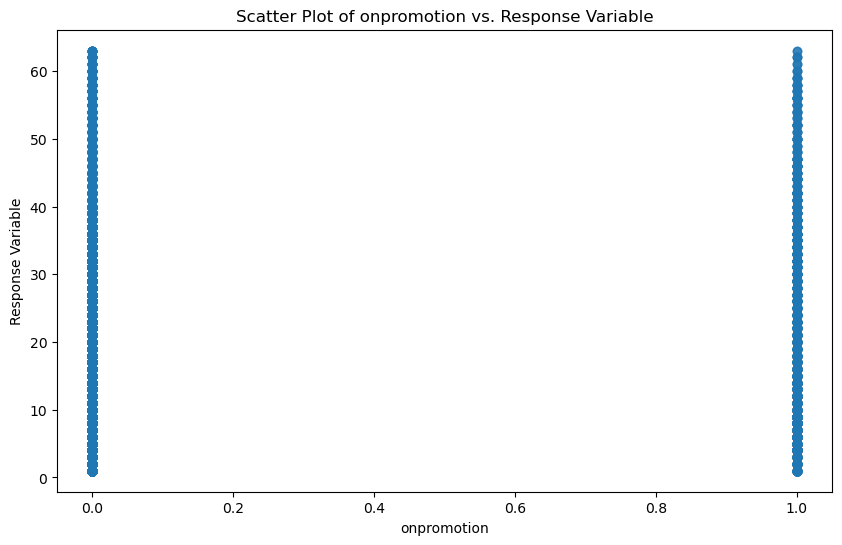

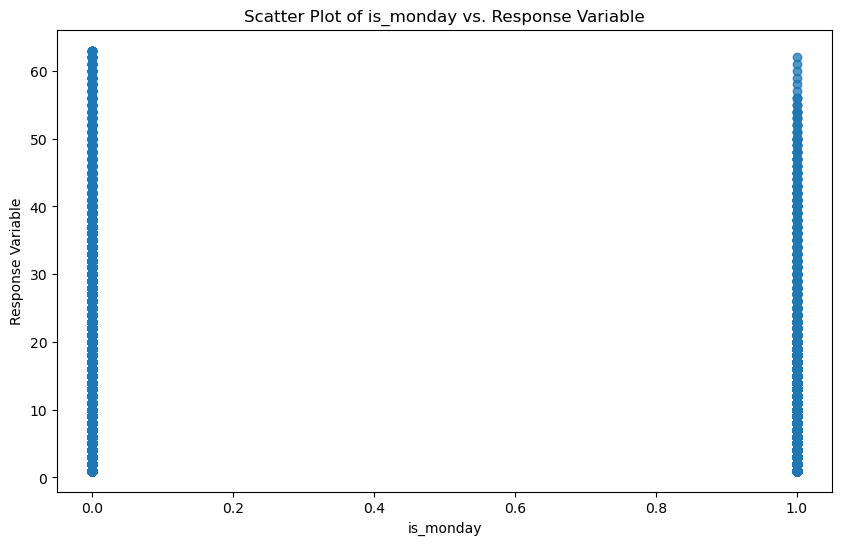

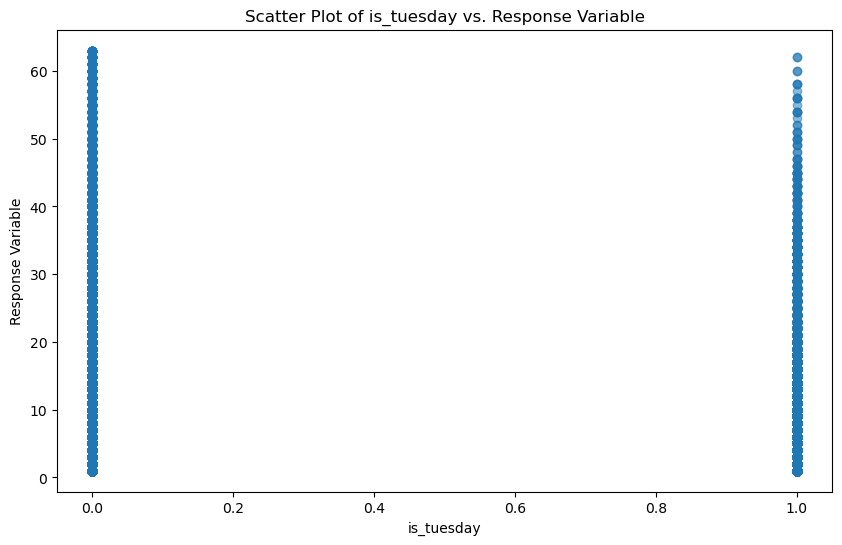

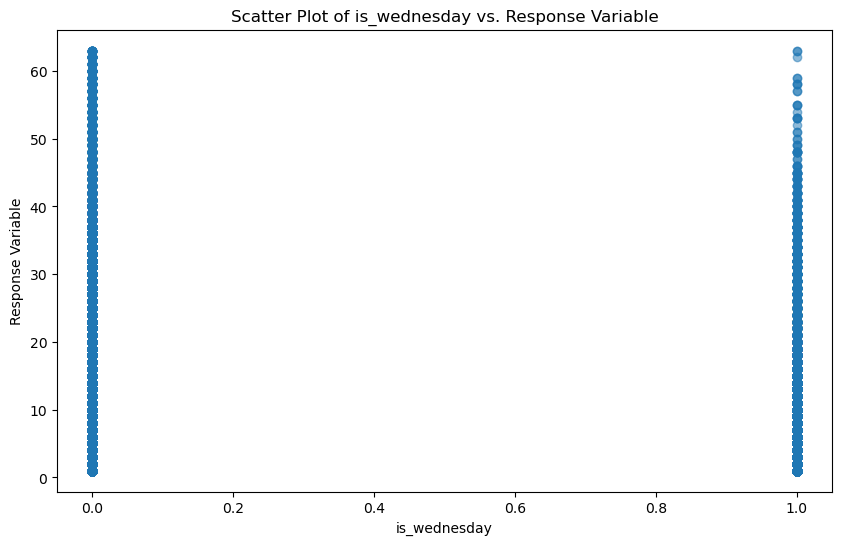

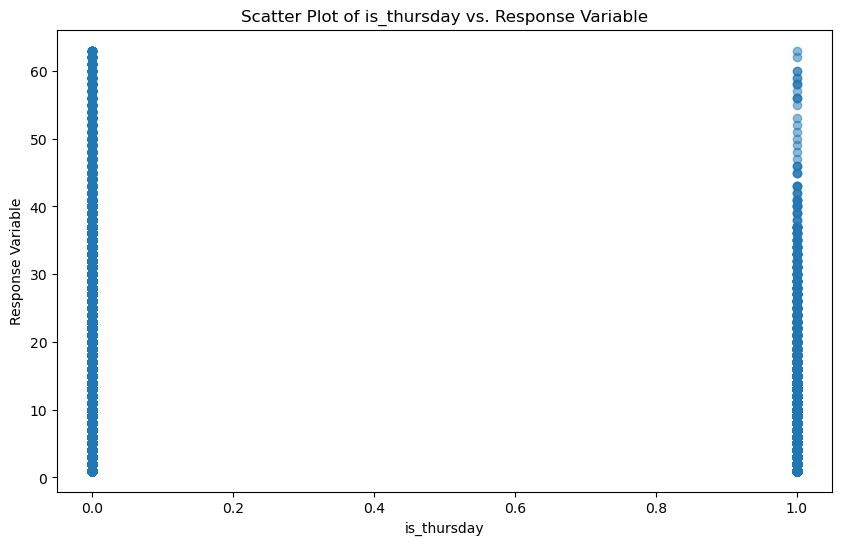

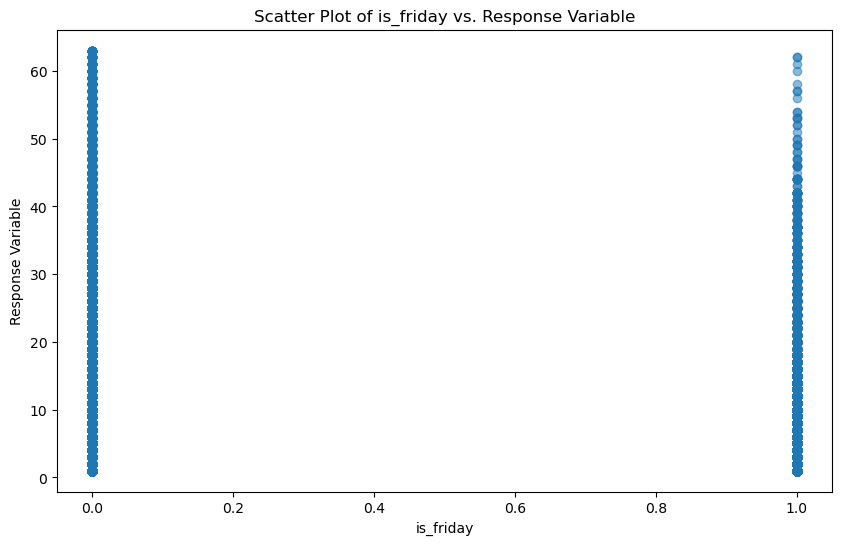

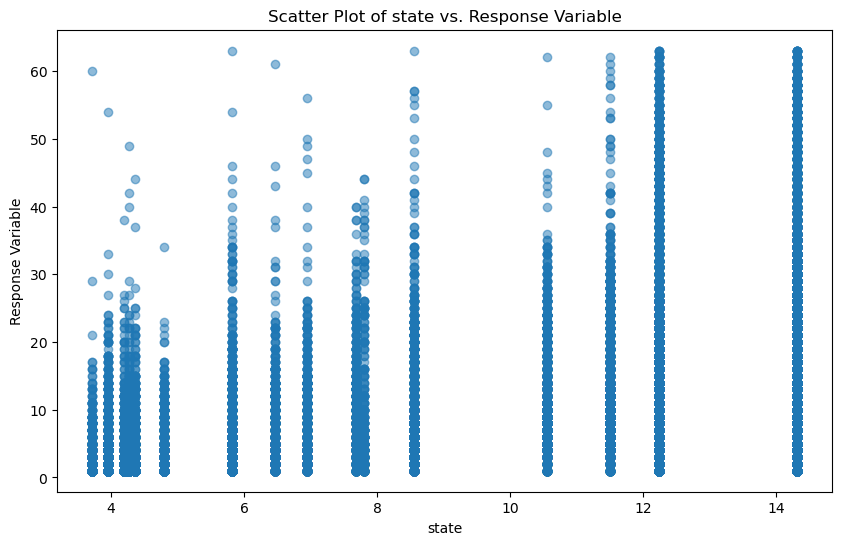

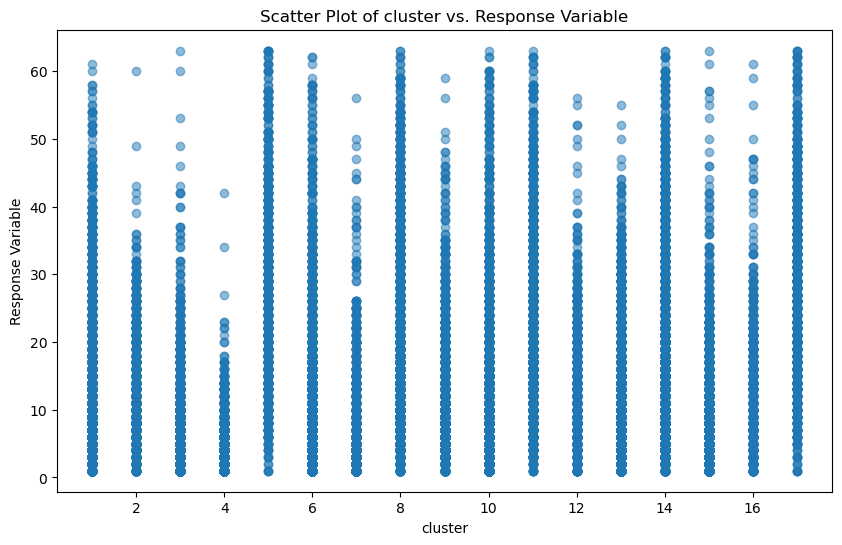

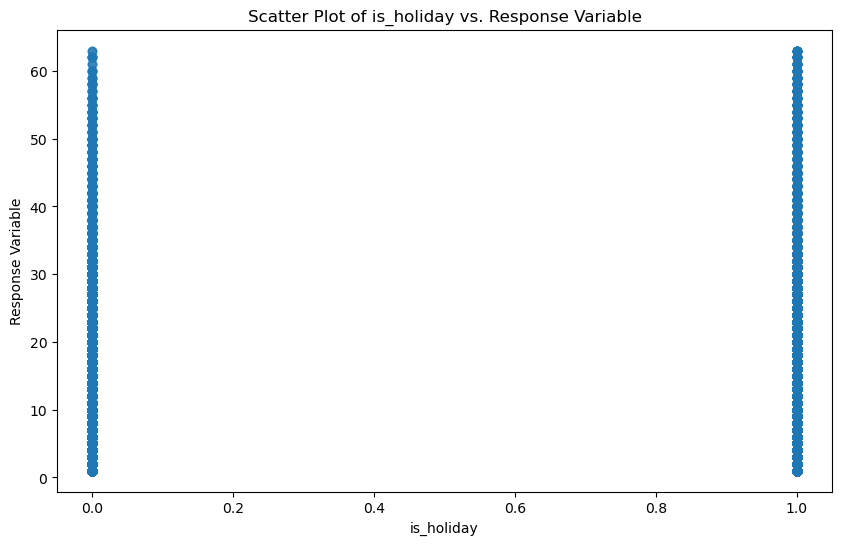

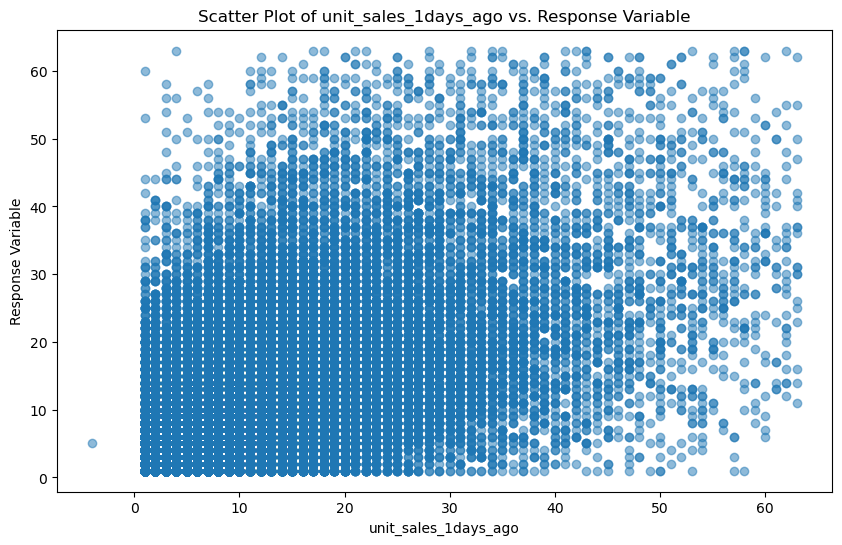

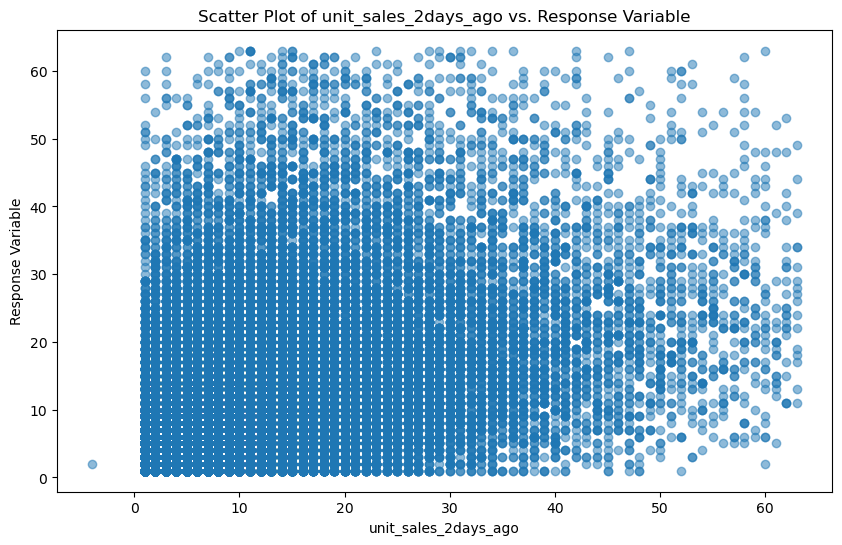

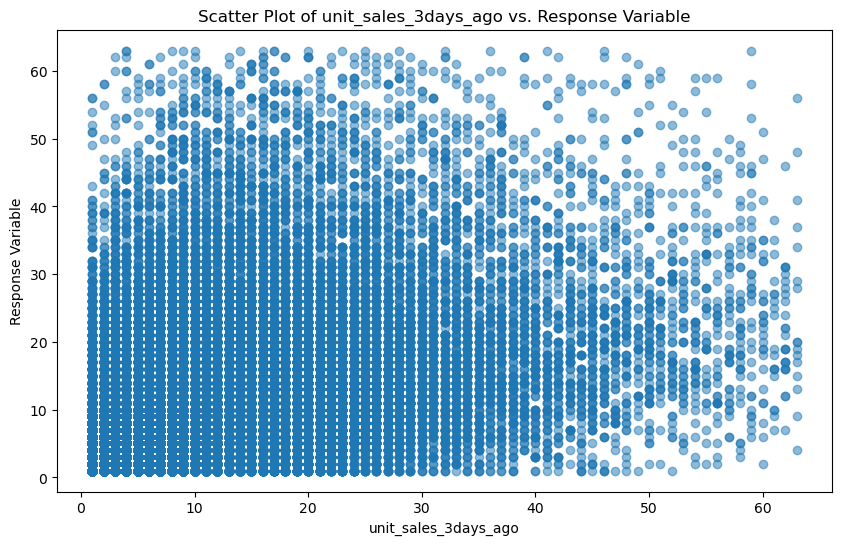

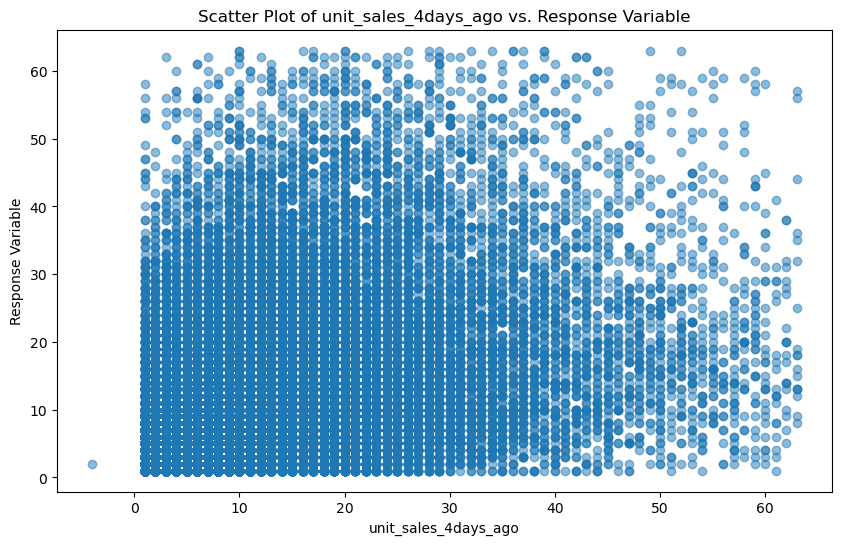

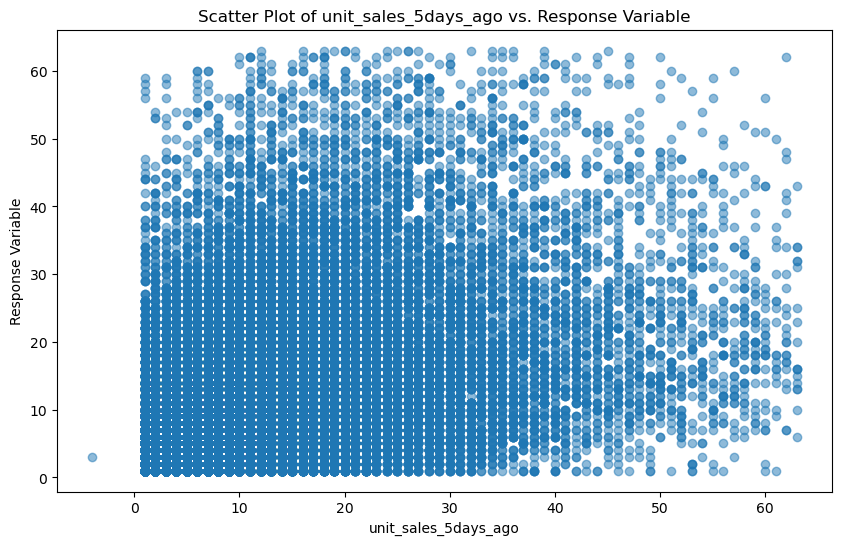

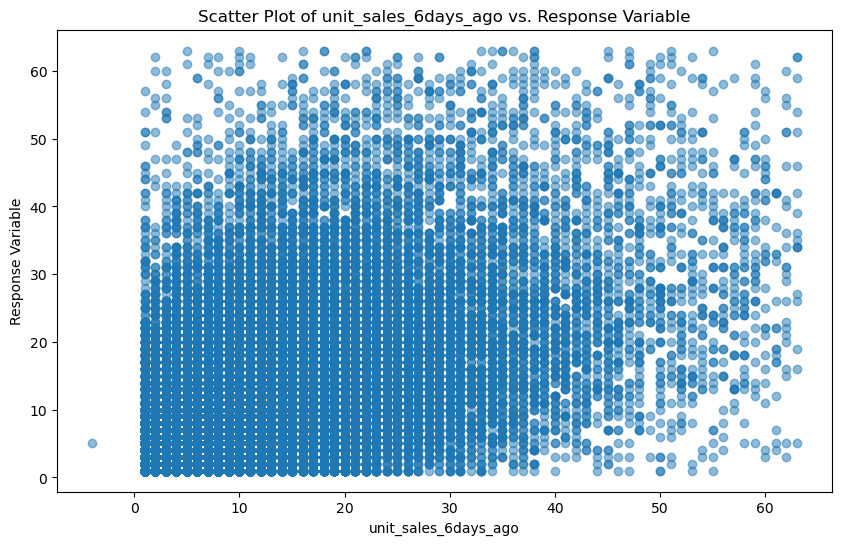

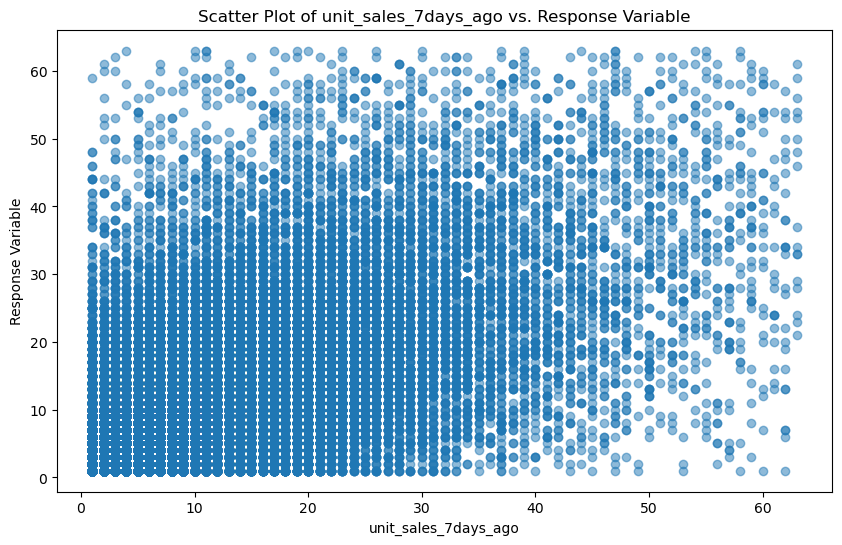

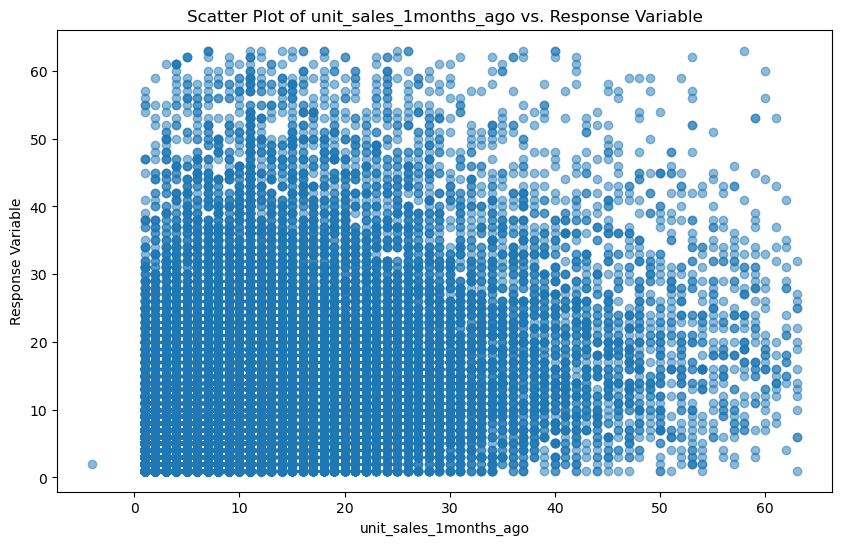

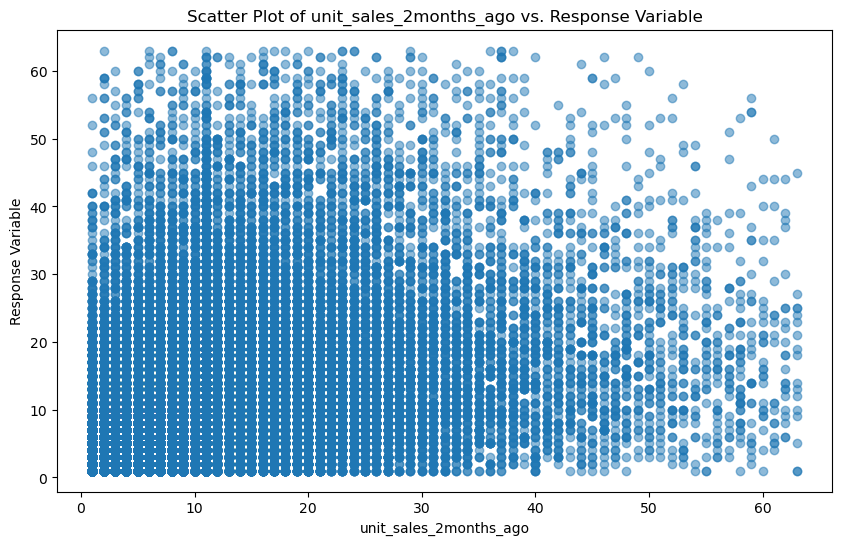

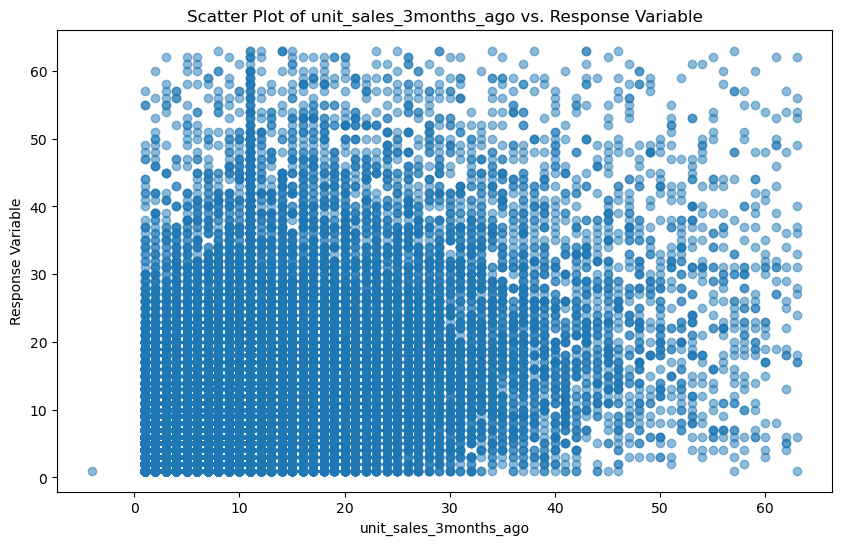

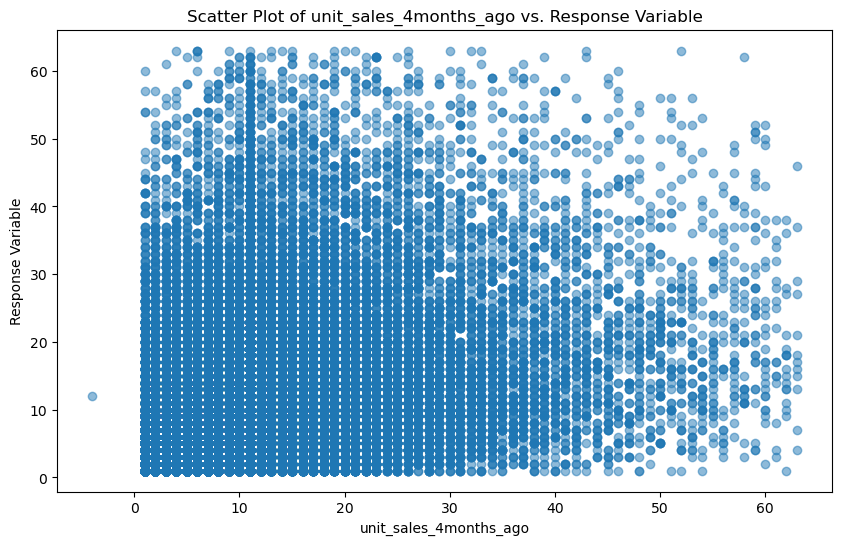

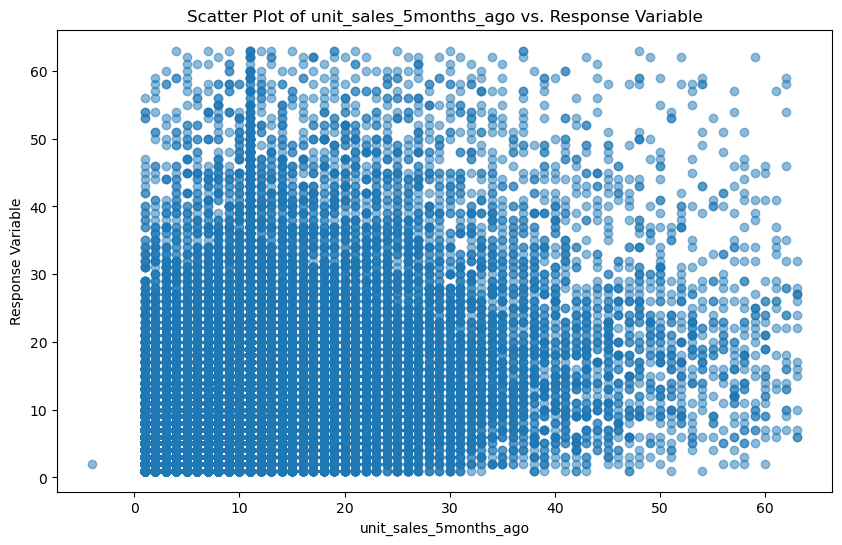

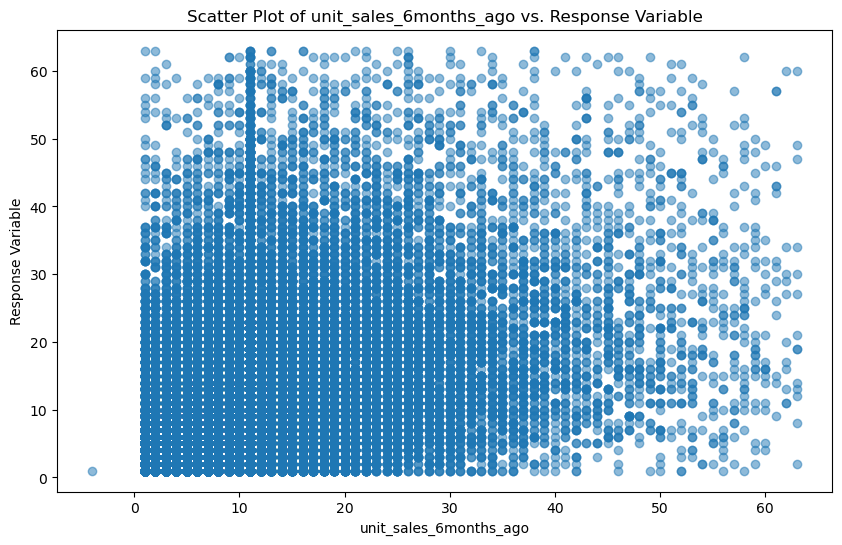

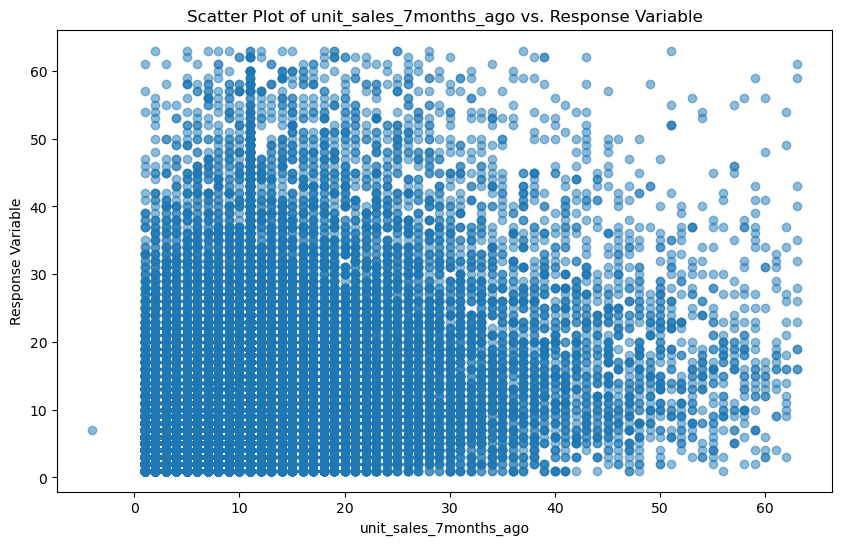

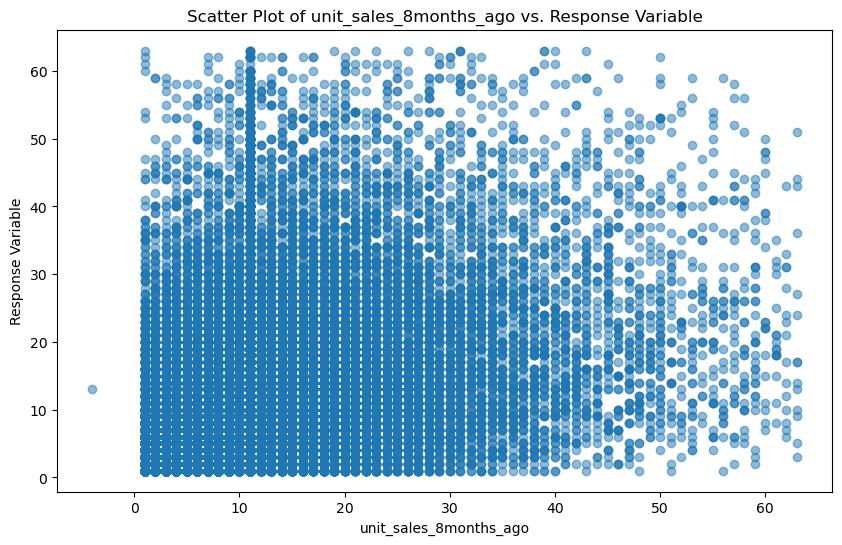

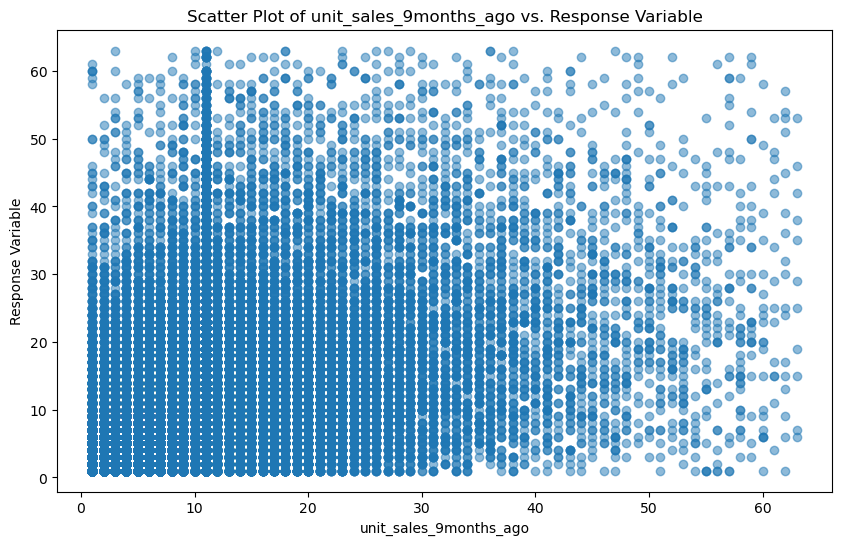

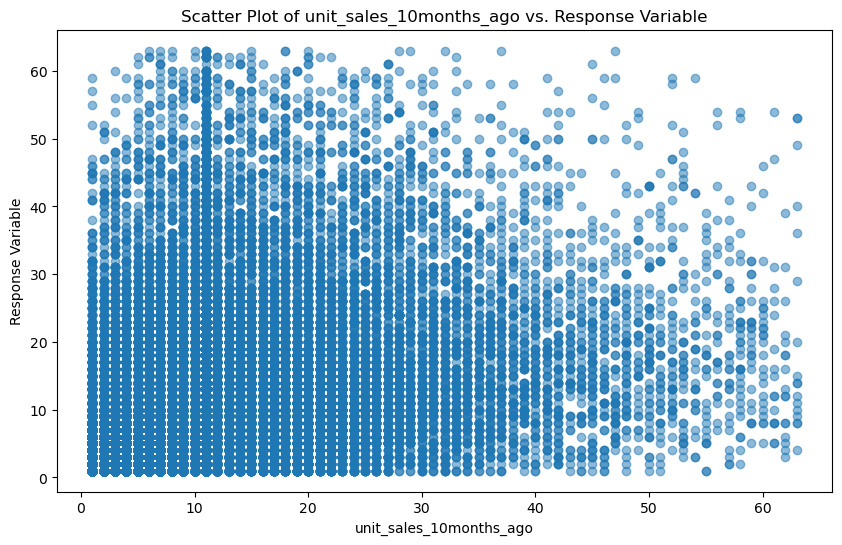

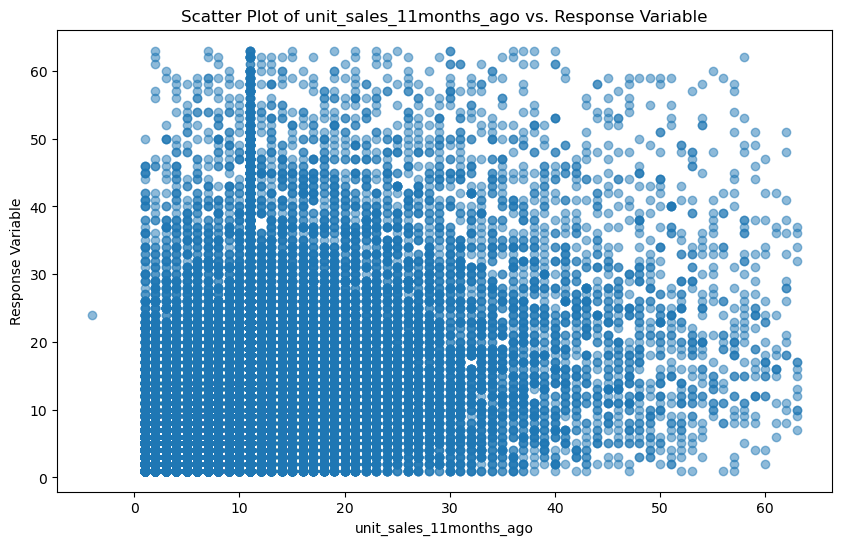

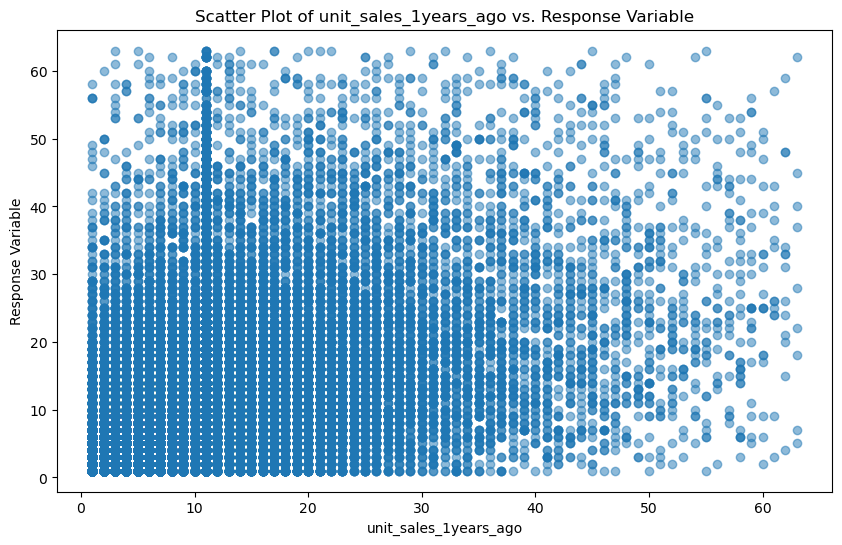

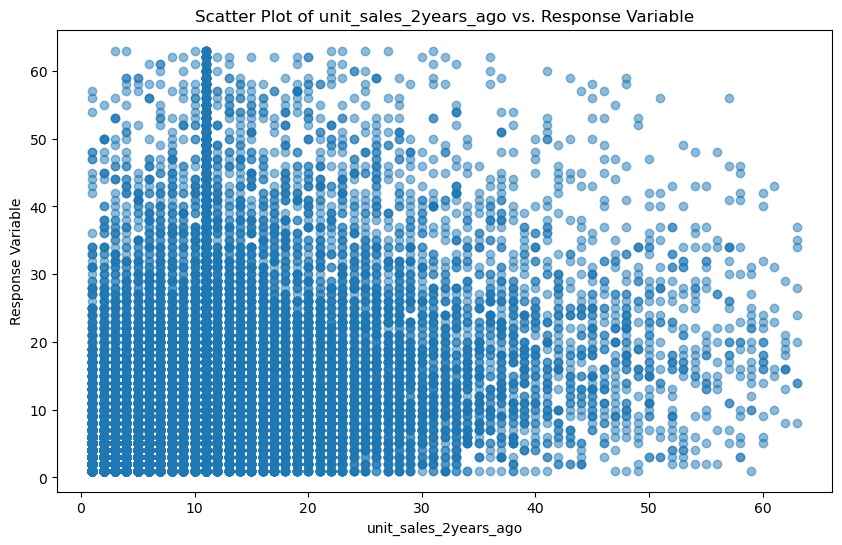

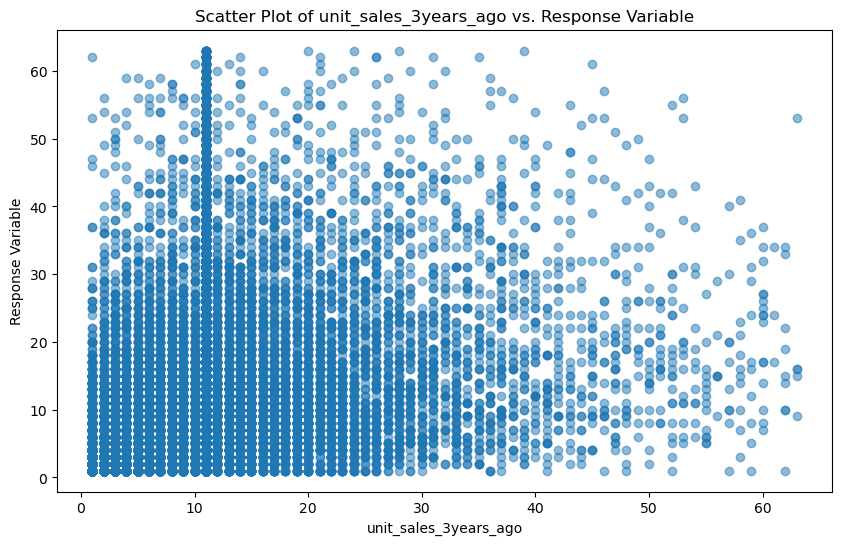

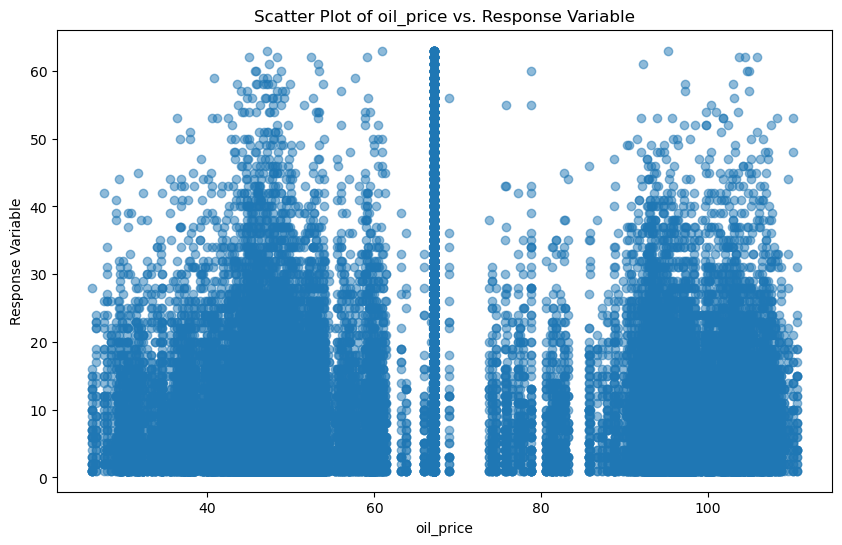

In [42]:
# Plot scatter plots for each predictor vs. the response variable
for column in X_train.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[column], y_train, alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Response Variable')
    plt.title(f'Scatter Plot of {column} vs. Response Variable')
    plt.show()

### 3. Independence of residuals

In [43]:
from statsmodels.stats.stattools import durbin_watson

# Fit the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", dw_stat)

Durbin-Watson statistic: 2.0008632158519712


- Ideal number, which show independence

### 4. Homoscedasticity

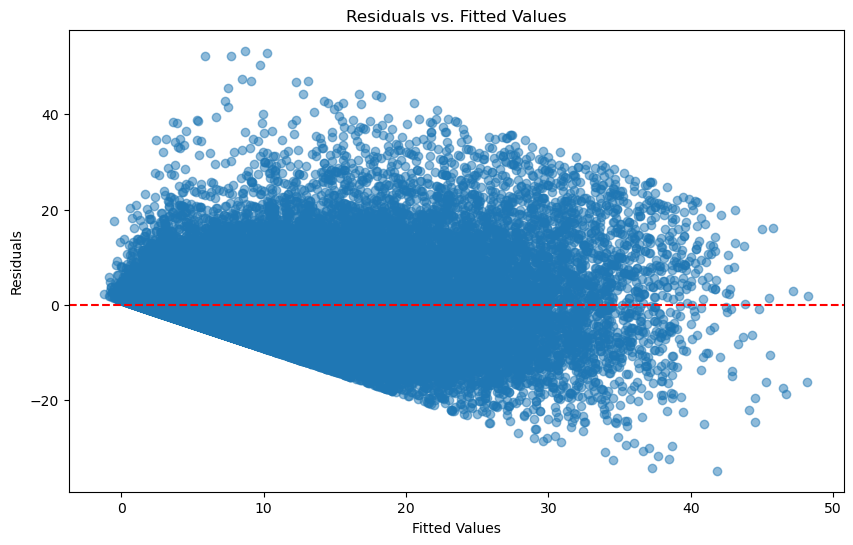

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [45]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Fit the model using statsmodels
X_train_with_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_with_const).fit()

# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
print("Breusch-Pagan test p-value:", bp_test[1])

Breusch-Pagan test p-value: 0.0


In [46]:
bp_test[1]<0.05

True

- A low p-value indicates potential heteroscedasticity (non-constant variance).

### 5. Normality of residuals

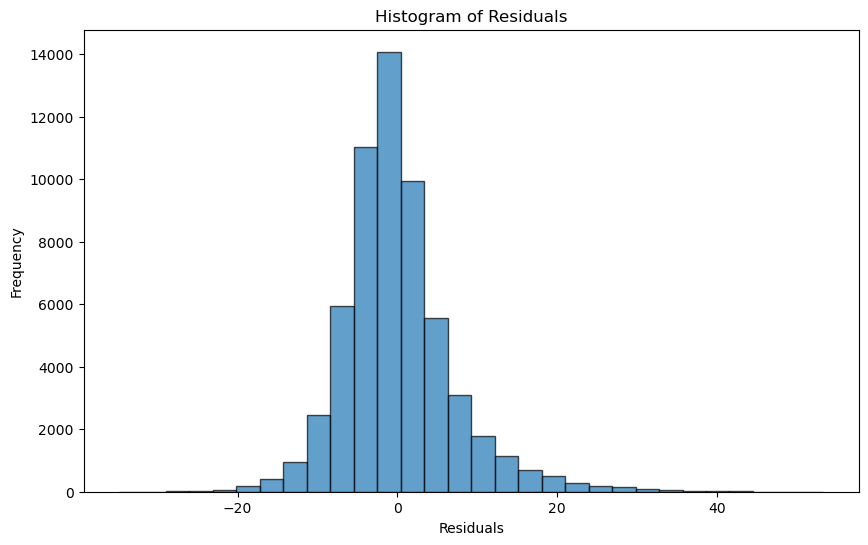

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

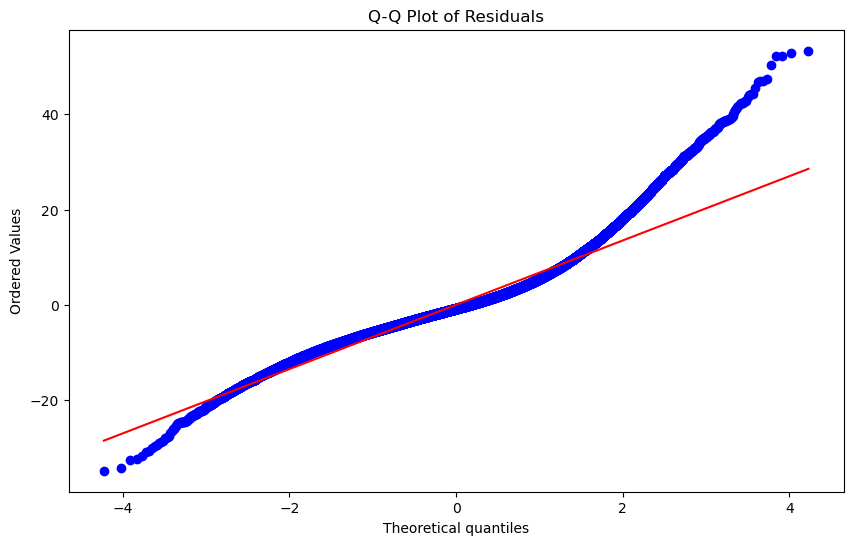

In [48]:
# Q-Q Plot: Plot quantiles of residuals against quantiles of a normal distribution
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [49]:
from scipy.stats import shapiro

# Shapiro-Wilk test
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)

Shapiro-Wilk test p-value: 0.0


In [50]:
shapiro_test.pvalue<0.05

True

- A p-value less than 0.05 suggests that the residuals significantly deviate from normality.

## Summary of analysis

The analysis reveals that there is no linear relationship between the predictor variables and the response variable. While residuals are independent, they display heteroscedasticity, indicating non-constant variance. Additionally, the residuals are not normally distributed.

Given the lack of linearity, heteroscedasticity, and non-normal residuals in our linear regression model, we plan to explore alternative approaches. We will consider Random Forest, a non-parametric model adept at handling non-linear relationships and interactions, and robust to heteroscedasticity and non-normal residuals. Additionally, we will examine Gradient Boosting Machines (GBM), an ensemble learning method that builds models sequentially to correct errors and capture complex relationships and interactions in the data.

In [51]:
X_train.columns

Index(['store_nbr', 'onpromotion', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'state', 'cluster', 'is_holiday',
       'unit_sales_1days_ago', 'unit_sales_2days_ago', 'unit_sales_3days_ago',
       'unit_sales_4days_ago', 'unit_sales_5days_ago', 'unit_sales_6days_ago',
       'unit_sales_7days_ago', 'unit_sales_1months_ago',
       'unit_sales_2months_ago', 'unit_sales_3months_ago',
       'unit_sales_4months_ago', 'unit_sales_5months_ago',
       'unit_sales_6months_ago', 'unit_sales_7months_ago',
       'unit_sales_8months_ago', 'unit_sales_9months_ago',
       'unit_sales_10months_ago', 'unit_sales_11months_ago',
       'unit_sales_1years_ago', 'unit_sales_2years_ago',
       'unit_sales_3years_ago', 'oil_price'],
      dtype='object')

In [52]:
len(X_train.columns)

32

## Random Forest Regressor

In [53]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate the model on the test set
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print("Random Forest Regressor:")
print("Test Mean Squared Error:", mse_rf_test)
print("Test R^2 Score:", r2_rf_test)

Random Forest Regressor:
Test Mean Squared Error: 45.47751004771642
Test R^2 Score: 0.5508238000022179


In [54]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                    Feature  Importance
16     unit_sales_7days_ago    0.271995
10     unit_sales_1days_ago    0.156650
15     unit_sales_6days_ago    0.048095
9                is_holiday    0.046055
11     unit_sales_2days_ago    0.035139
13     unit_sales_4days_ago    0.030933
14     unit_sales_5days_ago    0.029965
12     unit_sales_3days_ago    0.029036
7                     state    0.025107
19   unit_sales_3months_ago    0.024190
28    unit_sales_1years_ago    0.022490
17   unit_sales_1months_ago    0.022305
18   unit_sales_2months_ago    0.020821
22   unit_sales_6months_ago    0.020519
24   unit_sales_8months_ago    0.019862
21   unit_sales_5months_ago    0.019601
25   unit_sales_9months_ago    0.019555
20   unit_sales_4months_ago    0.019159
0                 store_nbr    0.018969
27  unit_sales_11months_ago    0.017878
23   unit_sales_7months_ago    0.017166
31                oil_price    0.016703
26  unit_sales_10months_ago    0.015983
29    unit_sales_2years_ago    0.013024


In [55]:
X_train = X_train.drop(['onpromotion', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'unit_sales_3years_ago'], axis = 1)
X_test = X_test.drop(['onpromotion', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'unit_sales_3years_ago'], axis = 1)
last_month_data = last_month_data.drop(['onpromotion', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'unit_sales_3years_ago'], axis = 1)

In [56]:
from sklearn.model_selection import cross_val_score, KFold
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Convert negative MSE to positive and calculate mean and std
mse_scores = -cv_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Random Forest Regressor Cross-Validation Mean MSE: {mean_mse:.4f}")
print(f"Random Forest Regressor Cross-Validation Std MSE: {std_mse:.4f}")

Random Forest Regressor Cross-Validation Mean MSE: 47.1150
Random Forest Regressor Cross-Validation Std MSE: 1.5526


In [57]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate the model on the test set
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print("Random Forest Regressor:")
print("Test Mean Squared Error:", mse_rf_test)
print("Test R^2 Score:", r2_rf_test)

Random Forest Regressor:
Test Mean Squared Error: 46.53366993865031
Test R^2 Score: 0.5403922287508015


## Gradient Boosting Regressor

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting model
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model
gbm_model.fit(X_train, y_train)

# Make predictions
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate the model
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print("Gradient Boosting Regressor:")
print("Mean Squared Error:", mse_gbm)
print("R^2 Score:", r2_gbm)

Gradient Boosting Regressor:
Mean Squared Error: 46.091333604463955
R^2 Score: 0.5447611344693052


In [59]:
# Initialize the Gradient Boosting model
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Evaluate the model using cross-validation
cv_scores_gbm = cross_val_score(gbm_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Convert negative MSE to positive and calculate mean and std
mse_scores_gbm = -cv_scores_gbm
mean_mse_gbm = np.mean(mse_scores_gbm)
std_mse_gbm = np.std(mse_scores_gbm)

print(f"GBM Regressor Cross-Validation Mean MSE: {mean_mse_gbm:.4f}")
print(f"GBM Regressor Cross-Validation Std MSE: {std_mse_gbm:.4f}")

GBM Regressor Cross-Validation Mean MSE: 46.9202
GBM Regressor Cross-Validation Std MSE: 1.6343


In [67]:
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model
gbm_model.fit(X_train, y_train)

# Make predictions
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate the model
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print("Gradient Boosting Regressor:")
print("Mean Squared Error:", mse_gbm)
print("R^2 Score:", r2_gbm)

Gradient Boosting Regressor:
Mean Squared Error: 46.091333604463955
R^2 Score: 0.5447611344693052


## Neural Networks

pip install tensorflow

Epoch 1/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 87.9617 - val_loss: 47.4742
Epoch 2/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 58.7489 - val_loss: 46.6565
Epoch 3/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 56.4156 - val_loss: 46.5773
Epoch 4/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 54.4850 - val_loss: 46.1487
Epoch 5/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 55.4946 - val_loss: 47.2715
Epoch 6/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 53.9515 - val_loss: 46.7372
Epoch 7/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 54.3170 - val_loss: 46.0647
Epoch 8/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 53.4599 - val_loss: 45.7301
Epoch 9/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 53.5124 - val_loss: 45.9172
Epoch 10/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 53.3541 - val_loss: 46.9527
Epoch 11/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 52.3765 - val_loss:

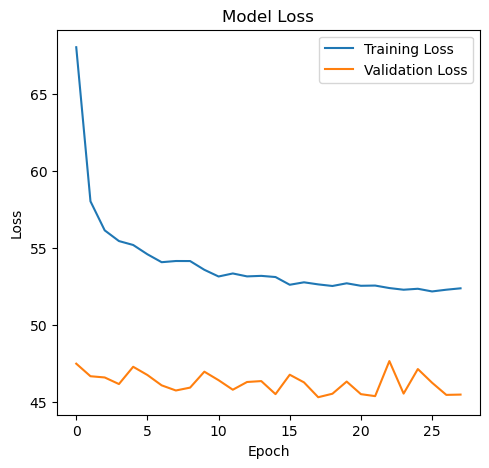

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model with dropout and L2 regularization
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and validation split
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
y_pred_nn = model.predict(X_test_scaled).flatten()

# Evaluate the model on the test set
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("Neural Network Regressor:")
print("Test Mean Squared Error:", mse_nn)
print("Test R^2 Score:", r2_nn)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Predicting last month unit sales

In [61]:
last_month_data.columns

Index(['date', 'store_nbr', 'unit_sales', 'city', 'state', 'store_type',
       'cluster', 'is_holiday', 'unit_sales_1days_ago', 'unit_sales_2days_ago',
       'unit_sales_3days_ago', 'unit_sales_4days_ago', 'unit_sales_5days_ago',
       'unit_sales_6days_ago', 'unit_sales_7days_ago',
       'unit_sales_1months_ago', 'unit_sales_2months_ago',
       'unit_sales_3months_ago', 'unit_sales_4months_ago',
       'unit_sales_5months_ago', 'unit_sales_6months_ago',
       'unit_sales_7months_ago', 'unit_sales_8months_ago',
       'unit_sales_9months_ago', 'unit_sales_10months_ago',
       'unit_sales_11months_ago', 'unit_sales_1years_ago',
       'unit_sales_2years_ago', 'oil_price'],
      dtype='object')

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
last_month_data

date  store_nbr  unit_sales       city      state  store_type  \
1500  2017-07-15          1         1.0  14.772353  14.310273   10.950917   
1501  2017-07-16          1         3.0  14.772353  14.310273   10.950917   
1502  2017-07-17          1         3.0  14.772353  14.310273   10.950917   
1503  2017-07-18          1        10.0  14.772353  14.310273   10.950917   
1504  2017-07-19          1         4.0  14.772353  14.310273   10.950917   
...          ...        ...         ...        ...        ...         ...   
74661 2017-08-07         53         2.0   3.925344   3.717269   10.950917   
74662 2017-08-08         53         6.0   3.925344   3.717269   10.950917   
74663 2017-08-09         53         3.0   3.925344   3.717269   10.950917   
74664 2017-08-12         53         1.0   3.925344   3.717269   10.950917   
74665 2017-08-14         53         1.0   3.925344   3.717269   10.950917   

       cluster  is_holiday  unit_sales_1days_ago  unit_sales_2days_ago  ...  \
1500        13           1                   5.0                   8.0  ...   
1501        13           1                   1.0                   5.0  ...   
1502        13           0                   3.0                   1.0  ...   
1503        13           0                   3.0                   3.0  ...   
1504        13           0                  10.0                   3.0  ...   
...        ...         ...                   ...                   ...  ...   
74661       13           0                   2.0                   1.0  ...   
74662       13           0                   2.0                   2.0  ...   
74663       13           0                   6.0                   2.0  ...   
74664       13           1                   3.0                   6.0  ...   
74665       13           0                   1.0                   3.0  ...   

       unit_sales_5months_ago  unit_sales_6months_ago  unit_sales_7months_ago  \
1500                      2.0                     3.0                     0.0   
1501                      2.0                     4.0                     0.0   
1502                      8.0                     7.0                     0.0   
1503                      4.0                     4.0                     3.0   
1504                      1.0                     0.0                    14.0   
...                       ...                     ...                     ...   
74661                     2.0                     4.0                     2.0   
74662                     1.0                     4.0                     6.0   
74663                     1.0                     4.0                     1.0   
74664                     3.0                     7.0                     0.0   
74665                     1.0                     1.0                     3.0   

       unit_sales_8months_ago  unit_sales_9months_ago  \
1500                      5.0                    14.0   
1501                     15.0                     5.0   
1502                      3.0                     5.0   
1503                      1.0                     7.0   
1504                      3.0                     1.0   
...                       ...                     ...   
74661                     1.0                     6.0   
74662                     0.0                     2.0   
74663                     3.0                     2.0   
74664                     2.0                     2.0   
74665                     0.0                     1.0   

       unit_sales_10months_ago  unit_sales_11months_ago  \
1500                       7.0                      5.0   
1501                       0.0                      2.0   
1502                       8.0                      7.0   
1503                       5.0                      1.0   
1504                      10.0                      4.0   
...                        ...                      ...   
74661                      1.0                      7.0   
74662   

In [64]:
last_month_data = last_month_data.drop(['city', 'store_type'], axis = 1)

In [65]:
# Assuming last_month_data is a pandas DataFrame with the structure described
# Removing the 'date' column for model input
feature_columns = last_month_data.drop(['date', 'unit_sales'], axis=1).columns.tolist()


# Iterate over the unique dates in last_month_data in sorted order
for current_date in sorted(last_month_data['date'].unique()):
    # Select rows for the current date
    current_day_data = last_month_data[last_month_data['date'] == current_date]

    # Ensure that current_day_data is not empty and feature_columns exist in the DataFrame
    if not current_day_data.empty and all(col in current_day_data.columns for col in feature_columns):
        X_current_day = current_day_data[feature_columns]
        y_pred_current_day = rf_model.predict(X_current_day)
    
        # Update the 'predicted_unit_sales' column with the predicted values
        last_month_data.loc[last_month_data['date'] == current_date, 'predicted_unit_sales'] = y_pred_current_day

        # Update the lag features for future dates
        next_date = pd.to_datetime(current_date) + pd.Timedelta(days=1)
        next_date_str = next_date.strftime('%Y-%m-%d')
        if next_date_str in last_month_data['date'].values:
            for index, store in enumerate(current_day_data['store_nbr']):
                predicted_value = y_pred_current_day[index]
                last_month_data.loc[
                    (last_month_data['date'] == next_date_str) & (last_month_data['store_nbr'] == store),
                    'unit_sales_1days_ago'
                ] = predicted_value
            for days_ago in range(2, 8):
                future_date = next_date + pd.Timedelta(days=days_ago - 1)
                future_date_str = future_date.strftime('%Y-%m-%d')
                if future_date_str in last_month_data['date'].values:
                    last_month_data.loc[
                        (last_month_data['date'] == future_date_str) & (last_month_data['store_nbr'] == store),
                        f'unit_sales_{days_ago}days_ago'
                    ] = last_month_data.loc[
                        (last_month_data['date'] == next_date_str) & (last_month_data['store_nbr'] == store),
                        'unit_sales_1days_ago'
                    ]


In [68]:
# Iterate over the unique dates in last_month_data in sorted order
for current_date in sorted(last_month_data['date'].unique()):
    # Select rows for the current date
    current_day_data = last_month_data[last_month_data['date'] == current_date]

    # Ensure that current_day_data is not empty and feature_columns exist in the DataFrame
    if not current_day_data.empty and all(col in current_day_data.columns for col in feature_columns):
        X_current_day = current_day_data[feature_columns]
        y_pred_current_day = gbm_model.predict(X_current_day)
    
        # Update the 'predicted_unit_sales' column with the predicted values
        last_month_data.loc[last_month_data['date'] == current_date, 'predicted_unit_sales_gbm'] = y_pred_current_day

        # Update the lag features for future dates
        next_date = pd.to_datetime(current_date) + pd.Timedelta(days=1)
        next_date_str = next_date.strftime('%Y-%m-%d')
        if next_date_str in last_month_data['date'].values:
            for index, store in enumerate(current_day_data['store_nbr']):
                predicted_value = y_pred_current_day[index]
                last_month_data.loc[
                    (last_month_data['date'] == next_date_str) & (last_month_data['store_nbr'] == store),
                    'unit_sales_1days_ago'
                ] = predicted_value
            for days_ago in range(2, 8):
                future_date = next_date + pd.Timedelta(days=days_ago - 1)
                future_date_str = future_date.strftime('%Y-%m-%d')
                if future_date_str in last_month_data['date'].values:
                    last_month_data.loc[
                        (last_month_data['date'] == future_date_str) & (last_month_data['store_nbr'] == store),
                        f'unit_sales_{days_ago}days_ago'
                    ] = last_month_data.loc[
                        (last_month_data['date'] == next_date_str) & (last_month_data['store_nbr'] == store),
                        'unit_sales_1days_ago'
                    ]

In [ ]:
# Standardize the feature columns for each current_day_data before making predictions
scaler = StandardScaler()

# Iterate over the unique dates in last_month_data in sorted order
for current_date in sorted(last_month_data['date'].unique()):
    # Select rows for the current date
    current_day_data = last_month_data[last_month_data['date'] == current_date]

    # Ensure that current_day_data is not empty and feature_columns exist in the DataFrame
    if not current_day_data.empty and all(col in current_day_data.columns for col in feature_columns):
        # Standardize the features for the current day
        X_current_day = scaler.fit_transform(current_day_data[feature_columns])
        
        # Make predictions using the neural network model
        y_pred_current_day = model.predict(X_current_day).flatten()
    
        # Update the 'predicted_unit_sales' column with the predicted values
        last_month_data.loc[last_month_data['date'] == current_date, 'predicted_unit_sales_nn'] = y_pred_current_day

        # Update the lag features for future dates
        next_date = pd.to_datetime(current_date) + pd.Timedelta(days=1)
        next_date_str = next_date.strftime('%Y-%m-%d')
        if next_date_str in last_month_data['date'].values:
            for index, store in enumerate(current_day_data['store_nbr']):
                predicted_value = y_pred_current_day[index]
                last_month_data.loc[
                    (last_month_data['date'] == next_date_str) & (last_month_data['store_nbr'] == store),
                    'unit_sales_1days_ago'
                ] = predicted_value
            
            # Update other unit_sales_*days_ago columns for future dates if needed
            for days_ago in range(2, 8):  # from 2 to 7 days ago
                future_date = next_date + pd.Timedelta(days=days_ago - 1)
                future_date_str = future_date.strftime('%Y-%m-%d')
                
                if future_date_str in last_month_data['date'].values:
                    last_month_data.loc[
                        (last_month_data['date'] == future_date_str) & (last_month_data['store_nbr'] == store),
                        f'unit_sales_{days_ago}days_ago'
                    ] = last_month_data.loc[
                        (last_month_data['date'] == next_date_str) & (last_month_data['store_nbr'] == store),
                        'unit_sales_1days_ago'
                    ]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 


In [ ]:
last_month_data

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize dictionaries to store the errors
mse_errors = {}
mae_errors = {}

# List of models to compare
model_columns = ['predicted_unit_sales', 'predicted_unit_sales_gbm', 'predicted_unit_sales_nn']

# Iterate over the model columns and compute errors
for model_col in model_columns:
    # Calculate MSE and MAE for each model
    mse = mean_squared_error(last_month_data['unit_sales'], last_month_data[model_col])
    mae = mean_absolute_error(last_month_data['unit_sales'], last_month_data[model_col])
    
    # Store the errors in the dictionaries
    mse_errors[model_col] = mse
    mae_errors[model_col] = mae

# Print the errors
print("Mean Squared Errors:")
for model, mse in mse_errors.items():
    print(f"{model}: {mse}")

print("\nMean Absolute Errors:")
for model, mae in mae_errors.items():
    print(f"{model}: {mae}")


In [ ]:
# Select a specific store number to visualize
specific_store_nbr = 1  # replace with the desired store number

# Filter the data for the specific store number
store_data = last_month_data[last_month_data['store_nbr'] == specific_store_nbr]

# Plot the actual and predicted unit_sales over time
plt.figure(figsize=(14, 8))

plt.plot(store_data['date'], store_data['unit_sales'], label='Actual Unit Sales', color='blue', marker='o')
plt.plot(store_data['date'], store_data['predicted_unit_sales'], label='RF Predicted Unit Sales', color='green', marker='x')
plt.plot(store_data['date'], store_data['predicted_unit_sales_gbm'], label='GBM Predicted Unit Sales', color='orange', marker='s')
plt.plot(store_data['date'], store_data['predicted_unit_sales_nn'], label='NN Predicted Unit Sales', color='red', marker='d')

plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.title(f'Actual vs Predicted Unit Sales for Store Number {specific_store_nbr}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary
The plot shows the actual unit sales compared to the predictions made by three different models: Random Forest (RF), Gradient Boosting Machine (GBM), and Neural Network (NN). The Random Forest and GBM models generally follow the trends of the actual sales but tend to be less volatile, underestimating some peaks and troughs. The Neural Network predictions appear smoother and more consistent but seem to overestimate sales compared to the actual data. Overall, while all models capture the general trends, they each have their distinct biases—Random Forest and GBM being more conservative and Neural Network providing a smoother but slightly overestimated trend. Further tuning and model evaluation may be necessary to improve their accuracy.

An R² value of 54% indicates that the models explain about 54% of the variance in the actual unit sales, which suggests that the models capture some trends but also leave a significant portion of the variance unexplained. This is reflected in the graph, where the predicted values generally follow the trend of the actual sales but do not perfectly align with them. The discrepancies, such as underestimating peaks and troughs, indicate that while the models have captured some underlying patterns, there are still significant differences between the predicted and actual values, consistent with the moderate R² values.